# 시계열 수치입력 수치 예측 모델(상태유지 순환신경망)
- 시계열 수치를 입력해서 다음 수치를 예측하는 모델
- 각 모델에 코사인(cosine) 데이터를 학습시킨 후, 처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터 예측을 얼마나 잘 하는 지 테스트

### 사용할 패키지 불러오기 

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
%matplotlib inline

#### 사용자 히스토리 클래스 

In [2]:
class CustomHistory(Callback):
        def init(self):
            self.train_loss = []
            self.val_loss = []
            
        def on_epoch_end(self, batch, logs={}):
            self.train_loss.append(logs.get('loss'))
            self.val_loss.append(logs.get('val_loss'))

#### 데이터셋 만들기 
- 생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들기 
- 이전 수치들을 입력하여 다음 수치를 예측하는 문제
    - 데이터는 이전 수치
    - 라벨은 다음 수치
- 다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성
- create_dataset() 함수는 시계열 수치를 입력받아 데이터셋을 생성
    - look_back 인자는 얼마만큼의 이전 수치를 데이터로 만들것인가를 결정

In [3]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
look_back = 40

### 1 데이터 셋 생성하기 
* 시간의 흐름에 따라 진폭이 -1.0에서 1.0사이로 변하는 1,600개의 실수값을 생성

In [5]:
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

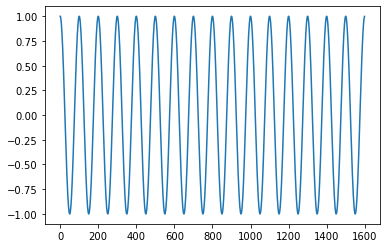

In [6]:
%matplotlib inline

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

#### 데이터 전처리

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

#### 데이터 분리

In [8]:
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

#### 데이터셋 생성

In [9]:
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

#### 데이터셋 전처리

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### 2 모델 구성하기 
- LSTM 
    - Long-Short Term Memory unit의 약자로 순환 신경망 레이어 중 하나
- tanh
    - LSTM의 출력 활성화 함수로 사용
- stateful = True
    - 상태유지가 가능한 순환신경망 모델 구성 
    - 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식 

In [11]:
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 32)                   4352      
_________________________________________________________________
dropout (Dropout)            (1, 32)                   0         
_________________________________________________________________
dense (Dense)                (1, 1)                    33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### 3. 모델 학습과정 설정하기

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')

### 4. 모델 학습시키기

In [13]:
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, validation_data=(x_val, y_val), callbacks=[custom_hist])
    model.reset_states()

760/760 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 1.7063e-04


760/760 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 2.6138e-04


760/760 [==============================] - 2s 3ms/step - loss: 0.0019 - val_loss: 1.3383e-04


### 5. 학습과정 살펴보기

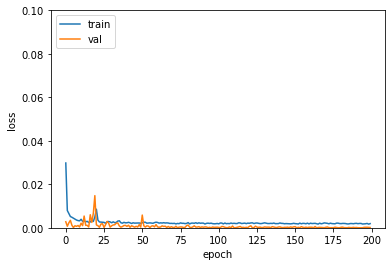

In [14]:
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.10)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()          

### 6. 모델 평가하기

In [15]:
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val,  batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test,  batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.00013671437045559287
Validataion Score:  0.00013382908946368843
Test Score:  0.00013382908946368843


### 7. 모델 사용하기

In [16]:
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):    
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])

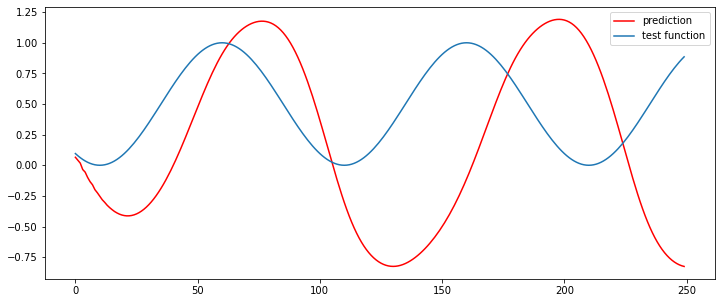

In [17]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()